# Analysis of Orbits in Fourier Space

Here we simulate Dan's Machine Learning system with rebound and then do a basic Fourier analysis. 

In [1]:
import numpy as np
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# Functions
Here are the functions we need to create to do a Fourier analysis

In [2]:
#extra variables that we might want to plot
def get_var(data,i,var):
    if var == "LCE":
        return data["LCE"]
    if var == "z":
        e = data["e"+i].values
        pomega = data["pomega"+i].values
        return e*np.exp(pomega*1j)
    if var == "h":
        e = data["e"+i].values
        pomega = data["pomega"+i].values
        return e*np.cos(pomega)
    if var == "k":
        e = data["e"+i].values
        pomega = data["pomega"+i].values
        return e*np.sin(pomega)
    else:
        return data[var+i].values

In [3]:
#1-D frequency map
import scipy.signal as signal
def fourier(data,var,tmax,N_outputs,output_name):
    lomb_analysis = 0
    
    t=data["Time"].values
    window = np.hanning(N_outputs)
    if lomb_analysis == 1:
        N_freq = 500
        Period = np.logspace(np.log10(tmax/N_outputs),np.log10(tmax),N_freq)
        freq = np.asarray([2*np.pi/P for P in Period])
    else:
        freq = np.fft.fftfreq(N_outputs, tmax/N_outputs)
    plt.figure(figsize=(12,8))
    names = ['Planet 1','Planet 2','Planet 3']
    for i,num in enumerate(['1', '2', '3']):
        plt.subplot(2, 1, 1)
        y = get_var(data,num,var)
        if lomb_analysis == 1:
            power = signal.lombscargle(t,np.absolute(y)*window,freq)
            plt.plot(Period,np.sqrt(4*power/N_outputs),label=names[i],alpha=1-0.2*i)
        else:
            power = np.absolute(np.fft.fft(y)/N_outputs)
            plt.plot(1./freq,power,label=names[i],alpha=1-0.2*i)
        plt.subplot(2, 1, 2)
        plt.plot(t,y,label=num,alpha=1-0.2*i)

    plt.subplots_adjust(hspace=0.4)
    plt.subplot(2, 1, 1)
    plt.ylabel("power of: "+var)
    plt.legend(loc="upper left")
    plt.xlabel('frequencies')
    plt.xscale('log')
    plt.subplot(2, 1, 2)
    plt.ylabel(var)
    plt.xlabel('time')
    if var == "LCE":
        plt.yscale('log')
    out = output_name.split(".csv")[0].split("data")[1]
    plt.savefig("Fourier/images"+out+"_fft-"+var+".png")
    plt.clf()

In [4]:
from matplotlib.colors import LogNorm
def fourier_map(files,columns,var,tmax,N_outputs):    
    freq = np.fft.fftfreq(N_outputs, tmax/N_outputs)
    power = np.zeros((1,3,N_outputs))
    window = np.hanning(N_outputs)
    for f in files:
        try:
            data = pd.read_csv(f,header=None,names=columns)
            t=data["Time"].values
            p = []
            for num in ['1', '2', '3']:
                y = get_var(data,num,var)
                p.append(np.absolute(np.fft.fft(y)/N_outputs))
            p = np.asarray(p)
            p = p.reshape((1,3,N_outputs))
            power = np.append(power, p, axis=0)
        except:
            print "File "+f+" has different number of N_outputs and/or tmax. Skipping."
    
    power = power[1:,:,:] #remove original np.zeros array used as a base for appending
    
    #plotting
    fig, ax = plt.subplots(3, sharex=True, figsize=(10,8))
    plt.subplots_adjust(hspace=0.1)
    ax[0].set_title("Power of "+str(var)+" for "+str(len(files))+" runs.",fontsize=20)
    ax[0].set_ylabel("Planet 1 (Run No.)")
    ax[1].set_ylabel("Planet 2 (Run No.)")
    ax[2].set_ylabel("Planet 3 (Run No.)")
    ax[2].set_xlabel("Frequency")
    im1 = ax[0].imshow(power[:,0,:],aspect="auto",interpolation="nearest",norm=LogNorm())
    im2 = ax[1].imshow(power[:,1,:],aspect="auto",interpolation="nearest",norm=LogNorm())
    im3 = ax[2].imshow(power[:,2,:],aspect="auto",interpolation="nearest",norm=LogNorm())
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im1, cax=cbar_ax, label='power')
    out = files[0].split(".csv")[0].split("data")[1].split("sd")[0]
    plt.savefig("Fourier/images"+out+"fftmap-"+var+".png")

# Fourier Map
Here we create a Fourier map.

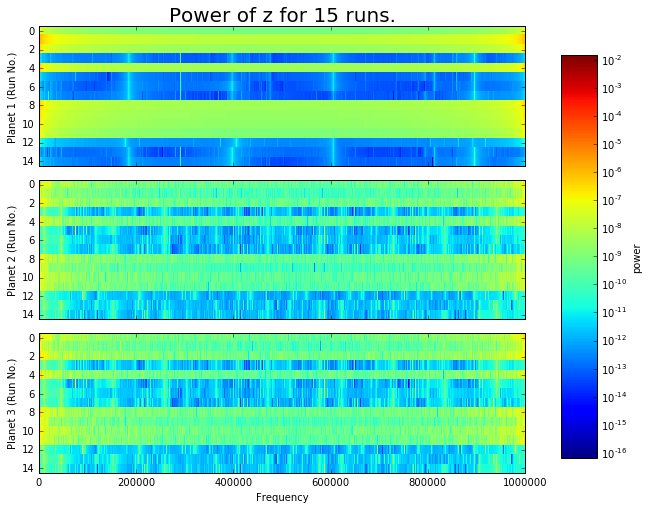

In [6]:
#Parameters
file_location = 'Fourier/data/DT_1e6_edgestability/'  #Location of where data is stored. 
var = "z"      #choices are h,k,z or any of the orbital elements (e.g. a,P,e,pomega,etc.)

#Create Fourier map
columns = ['Time']
for i in ['1', '2', '3']:
    columns += ['a'+i, 'P'+i, 'e'+i, 'pomega'+i, 'inc'+i, 'Omega'+i, 'f'+i]
files = glob.glob(file_location+"*.csv")
tmax = float(files[0].split("_")[-3].split("t")[1])
data = pd.read_csv(files[0],header=None,names=columns)
N_outputs = len(data.index)
fourier_map(files,columns,var,tmax,N_outputs)

# Analyze Individual Runs (Batch job)
Let's batch analyze our data now (note you may have to change the file_location variable).

In [7]:
#If just wanting to batch analyze .csv files
file_location = 'Fourier/data/DT_1e6_edgestability/'  #Location of where data is stored. 
var = "z"                        #choices are h,k,z or any of the orbital elements (e.g. a,P,e,pomega,etc.)

In [8]:
import glob
files = glob.glob(file_location+"*.csv")
columns = ['Time']
for i in ['1', '2', '3']:
    columns += ['a'+i, 'P'+i, 'e'+i, 'pomega'+i, 'inc'+i, 'Omega'+i, 'f'+i]

for f in files:
    data = pd.read_csv(f,header=None,names=columns)
    tmax = float(f.split("_")[-3].split("t")[1])
    N_outputs = len(data.index)
    fourier(data,var,tmax,N_outputs,f)

/Users/silburt/anaconda2/envs/ml/lib/python2.7/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
